In [9]:
import os
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf

In [2]:
tf.enable_eager_execution()
tf.VERSION

'1.13.1'

# Pose estimation

## Get started

*PoseNet* is a vision model that can be used to estimate the pose of a person in an image or video by estimating where key body joints are.

## How it works

Pose estimation refers to computer vision techniques that detect human figures in images and videos, so that one could determine, for example, where someone's elbow shows up in an image.

To be clear, this technology is not recognizing who is in an image. The algorithm is simply estimating where key body joints are.

The key points detected are indexed by "Part ID", with a confidence score between `0.0` and `1.0`, `1.0` being the highest.

|Id|Part|
|--|----|
|0|nose|
|1|leftEye|
|2|rightEye|
|3|leftEar|
|4|rightEar|
|5|leftShoulder|
|6|rightShoulder|
|7|leftElbow|
|8|rightElbow|
|9|leftWrist|
|10|rightWrist|
|11|leftHip|
|12|rightHip|
|13|leftKnee|
|14|rightKnee|
|15|leftAnkle|
|16|rightAnkle|

## How it performs

Performance varies based on your device and output stride (heatmaps and offset vectors). The PoseNet model is image size invariant, which means it can predict pose positions in the same scale as the original image regardless of whether the image is downscaled. This means PoseNet can be cocnfigured to have a higher accuracy at the expense of performance.

The output stride determines how much we're scaling down the output relative to the input image size. It affects the size of the layers and the model outputs. The higher the output stride, the smaller the resolution of layers in the network and the outputs, and correspondingly their accuracy. In this implementation, the output stride can have values of 8, 16, or 32. In other words, an output stride of 32 will result in the fastest performance but lowest accuracy, while 8 will result in the highest accuracy but slowest performance. We recommend starting with 16.

The following image shows how the output stride determines how much we're scaling down the output relative to the input image size. A higher output stride is faster but results in lower accuracy.

In [3]:
# Load TFLite model and allocate tensors
model_path = 'multi_person_mobilenet_v1_075_float.tflite'
interpreter = tf.lite.Interpreter(model_path)
interpreter.allocate_tensors()

In [4]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
input_details

[{'name': 'sub_2',
  'index': 97,
  'shape': array([  1, 353, 257,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [6]:
output_details

[{'name': 'float_heatmaps',
  'index': 93,
  'shape': array([ 1, 23, 17, 17]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_short_offsets',
  'index': 96,
  'shape': array([ 1, 23, 17, 34]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_mid_offsets',
  'index': 94,
  'shape': array([ 1, 23, 17, 64]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_segments',
  'index': 95,
  'shape': array([ 1, 23, 17,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

- `inputs`: a RGB image - shape `[353, 257, 3]` - with values is scaled between `0.0` and `1.0`
- `outputs`:

    - `float_heatmaps` - shape `[23, 17, 17]`
    - `float_short_offsets` - shape `[23, 17, 34]`
    - `float_mid_offsets` - shape `[23, 17, 64]`
    - `float_segments` - shape `[23, 17, 1]`

[  1 353 257   3]
width: 257, height: 353


<IPython.core.display.Javascript object>


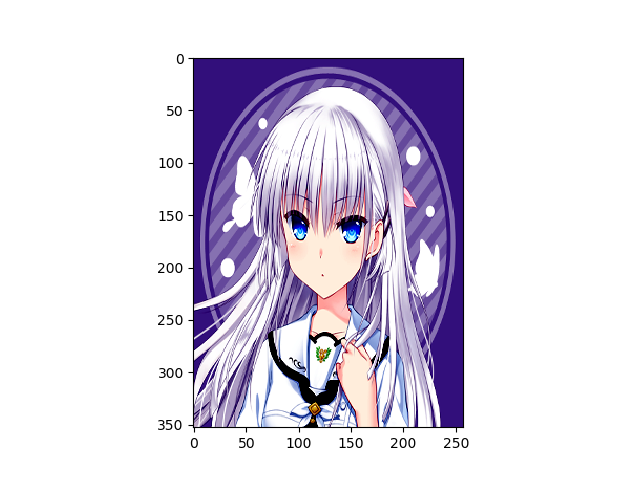

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(353, 257, 3)
(1, 353, 257, 3)


In [57]:
# Test model on input data
input_shape = input_details[0]['shape']
print(input_shape)
height, width = input_shape[1:3]
print(f'width: {width}, height: {height}')

img_filename = 'shiroha.png'
img = Image.open(img_filename)
img = np.array(img, dtype=np.uint8)

img = cv2.cvtColor(src=img, code=cv2.COLOR_RGBA2RGB)

img = cv2.resize(src=img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)

# img = img.astype(np.float32) / 255.0

img = img.astype(float)
img = img * (2.0 / 255.0) - 1.0

plt.imshow(img)
print(img.shape)

input_data = np.reshape(img, input_shape)
print(input_data.shape)

input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

In [27]:
import IPython.display as display

In [58]:
for idx, output_layer in enumerate(output_details):
    tensor = interpreter.get_tensor(output_layer['index'])
    
    layer_data = tensor[0]
    
    print('='*10, output_layer['name'], '='*10)
    
    print('tensor.shape:', tensor.shape)
    print('layer_data:', layer_data.shape)
    
    print(layer_data[:, :, 0].shape)
#     break

========== float_heatmaps ==========
tensor.shape: (1, 23, 17, 17)
layer_data: (23, 17, 17)
(23, 17)
========== float_short_offsets ==========
tensor.shape: (1, 23, 17, 34)
layer_data: (23, 17, 34)
(23, 17)
========== float_mid_offsets ==========
tensor.shape: (1, 23, 17, 64)
layer_data: (23, 17, 64)
(23, 17)
========== float_segments ==========
tensor.shape: (1, 23, 17, 1)
layer_data: (23, 17, 1)
(23, 17)


In [41]:
%matplotlib notebook

# float_heatmaps

- value is less than `0.0`

In [59]:
float_heatmaps = interpreter.get_tensor(output_details[0]['index'])[0]
float_heatmaps.shape

(23, 17, 17)

In [60]:
float_heatmaps.shape[-3]

23

In [61]:
for i in range(float_heatmaps.shape[-1]):
    print(np.max(float_heatmaps[:, :, i]))

-7.6527815
-7.310478
-6.9057145
-7.444385
-6.5267982
-5.6741295
-6.1007934
-5.7052774
-5.199486
-6.884478
-6.0788407
-4.6236057
-4.3400154
-5.070316
-5.5994143
-5.7186713
-5.5532866


In [62]:
flatten_float_heatmaps = float_heatmaps.flatten()
for val in flatten_float_heatmaps:
#     if val 
    print(val)

-10.063012
-9.077806
-7.6540165
-8.495864
-7.483039
-6.7618895
-9.628375
-8.154567
-9.223395
-9.483895
-9.039861
-9.628075
-9.00941
-8.652456
-9.263414
-9.645638
-9.8758955
-10.937898
-10.314236
-10.622048
-7.9160056
-7.7638927
-6.210125
-7.7593203
-9.321302
-9.455575
-9.250723
-9.139009
-8.894549
-8.358531
-7.8501
-8.545649
-8.934343
-9.028264
-11.167358
-10.782656
-11.064219
-8.747781
-8.605949
-7.1399894
-6.777444
-8.876463
-8.337586
-8.895143
-8.874646
-7.9668636
-6.870179
-8.537065
-9.391758
-8.72312
-8.780165
-11.487376
-11.888134
-11.485444
-8.829937
-9.453733
-7.7959743
-6.1007934
-9.004789
-7.502187
-8.597556
-8.458005
-8.107455
-7.073756
-8.805604
-9.5007515
-8.805428
-8.653963
-11.862276
-12.288488
-12.656233
-10.515514
-10.870125
-8.134234
-6.763896
-9.437486
-8.375958
-9.621824
-9.442543
-7.3635845
-6.753215
-9.19697
-9.51564
-9.520072
-8.887564
-12.272904
-12.398692
-12.695729
-10.778421
-10.745165
-8.25279
-7.3159256
-9.058581
-8.713106
-9.323496
-9.635696
-7.148507
-6.8

-7.1243167
-9.1059
-7.8258696
-7.4401093
-6.2866616
-8.109486
-7.1415105
-9.17301
-8.847737
-11.834463
-14.481321
-11.807753
-13.663992
-10.981413
-10.793672
-8.275398
-9.287792
-7.418869
-10.633761
-9.172669
-8.113434
-6.6198597
-8.291955
-6.705094
-9.86317
-9.217054
-11.011029
-13.235873
-12.117789
-13.798968
-12.515799
-10.883335
-9.058826
-8.863449
-6.966503
-10.132986
-8.59614
-8.081922
-6.2163396
-7.4650607
-6.3558083
-10.025271
-8.991163
-10.850938
-13.803068
-12.932278
-14.547523
-12.373913
-11.167624
-9.115678
-10.066646
-7.6272135
-10.866931
-8.857155
-7.4358387
-5.8329153
-7.5411077
-6.445989
-9.776717
-9.106559
-10.899564
-13.78657
-12.714008
-14.701811
-12.072364
-10.85645
-9.156479
-9.864307
-7.8086467
-10.524166
-8.658748
-6.7877917
-5.0562887
-7.3650527
-6.502788
-9.584196
-9.5659
-10.926861
-13.921106
-12.921067
-14.843482
-12.4846
-10.975215
-9.428884
-9.768296
-8.18407
-9.842746
-8.375302
-6.102012
-4.8017416
-6.57017
-6.289355
-8.896259
-9.039188
-10.692378
-13.8891

-7.6244254
-4.717533
-6.3852525
-6.2475314
-6.8820477
-8.001803
-8.277378
-11.350311
-11.98237
-10.526769
-9.51046
-10.844572
-6.5054893
-8.773365
-6.8169775
-8.27556
-8.557039
-7.724708
-5.3570356
-6.399872
-6.5845494
-6.3611374
-8.020055
-7.7563543
-9.567054
-10.396257
-9.711415
-8.866979
-9.88108
-6.0042176
-7.684349
-6.7441072
-7.431199
-7.1302147
-7.2011957
-5.4935126
-5.587772
-6.5504613
-6.120682
-7.690085
-7.340745
-10.330103
-10.935768
-9.793047
-10.402171
-10.522284
-9.931601
-8.411297
-8.566618
-8.08434
-8.198668
-8.961818
-8.232626
-8.445431
-9.165571
-10.068335
-9.839214
-9.735378
-9.942403
-11.556284
-9.817634
-11.573281
-10.3243265
-8.576051
-7.379129
-8.688267
-7.2489214
-8.943332
-9.08483
-7.855056
-7.016353
-8.685867
-9.29258
-9.40884
-9.116278
-10.818246
-13.049321
-10.255844
-12.591186
-11.049857
-9.642329
-8.223209
-8.703137
-6.3487954
-8.655396
-8.38852
-8.290584
-7.108822
-8.518342
-8.396891
-9.888275
-9.548186
-10.643684
-12.376822
-10.073317
-11.741977
-10.9026

<IPython.core.display.Javascript object>


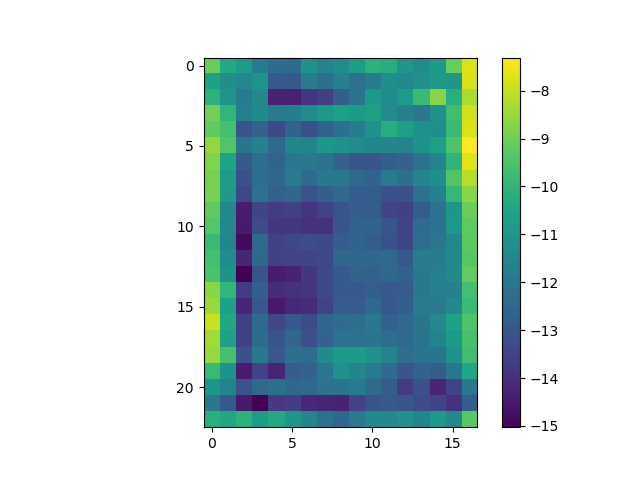

In [63]:
plt.imshow(float_heatmaps[:, :, 1])
plt.colorbar()

# float_short_offsets

- value range between `0.0` and `1.0`

In [37]:
float_short_offsets = interpreter.get_tensor(output_details[1]['index'])[0]
float_short_offsets.shape

(23, 17, 34)

<IPython.core.display.Javascript object>


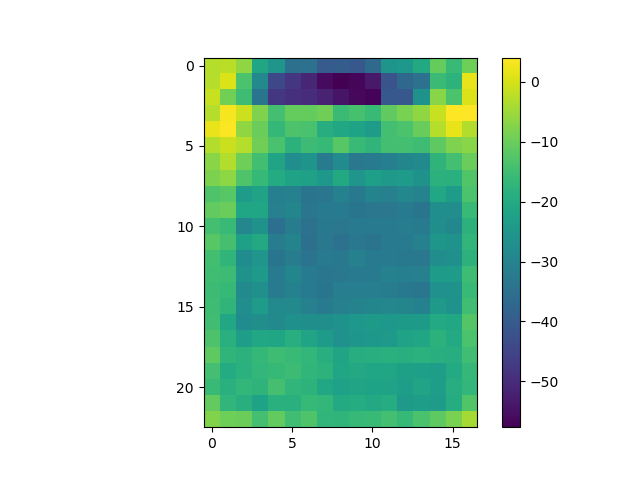

In [64]:
plt.imshow(float_short_offsets[:, :, 1])
plt.colorbar()

In [65]:
flatten_float_short_offsets = float_short_offsets.flatten()
for val in flatten_float_short_offsets:
    if val >= 0 and val <= 1:
        print(val)

0.44745478
0.9271986
0.6120311
0.044778943
0.5179635
0.053444926
0.6334986
0.7106731
0.7747257
0.8970207
0.30512795
0.29472145
0.29597697
0.67968935
0.5136519
0.009479266
0.43773496
0.9074877
0.27453074
0.7161169
0.7703085
0.22093828
0.104825355
0.31589863
0.04443552
0.61388826
0.8592025
0.28011033
0.0011956729
0.7753264
0.27471554
0.906906
0.041539773
0.5404408
0.35775736
0.89132607
0.3697985
0.5297043
0.9504566
0.95027614
0.35975093
0.04019618
0.664804
0.6479032
0.0789703
0.6936722
0.59600675
0.16060126
0.540909
0.7973587
0.0068613887
0.25052336
0.65984046
0.119557515
0.6953489
0.08140027
0.85352093
0.14355473
0.6620707
0.49455088
0.8478024
0.6261156
0.28889847
0.7507392
0.9298683
0.5517899
0.15876096
0.121647224
0.1756994
0.25805196
0.63799536
0.6592913
0.44365892
0.9662428
0.7594451
0.082269296
0.9338402
0.49263212
0.64624393
0.84461904
0.060914945
0.99931055
0.5392902
0.7401875
0.001973825
0.5250489
0.3900524
0.72457695
0.060471065
0.33247635
0.07436073
0.6025048
0.702898
0.075010

# float_mid_offsets

- value range between `0.0` and `1.0`

In [38]:
float_mid_offsets = interpreter.get_tensor(output_details[2]['index'])[0]
float_mid_offsets.shape

(23, 17, 64)

In [53]:
flatten_float_mid_offsets = float_mid_offsets.flatten()
for val in flatten_float_mid_offsets:
    if val >= 0 and val <= 1:
        print(val)

0.5184382
0.11560118
0.23377226
0.8662313
0.6370793
0.32942888
0.20487481
0.44372576
0.73023623
0.10070547
0.14532734
0.9010233
0.10378931
0.6779805
0.15814182
0.60751593
0.095237166
0.37170568
0.11225636
0.9510821
0.03147678
0.5075066
0.62992126
0.46135134
0.225751
0.26874825
0.26445323
0.6613672
0.35523602
0.6164259
0.3044934
0.6817028
0.3147206
0.12586501
0.744488
0.8143
0.96232766
0.502067
0.22175479
0.18349315
0.7876656
0.18818504
0.48453137
0.10248475
0.09144884
0.5157937
0.32175484
0.8842188
0.54726976
0.68400866
0.9325594
0.39902145
0.20782918
0.22487114
0.4912194
0.062011458
0.5085735
0.17394032
0.076873414
0.19202931
0.22299097
0.12711444
0.42389095
0.14974983
0.63599473
0.05364865
0.5282633
0.6149538
0.51062876
0.7494831
0.6299809
0.88742584
0.8501084
0.54639095
0.62667674
0.15805735
0.18478575
0.79705477
0.07336815
0.21619098
0.8380143
0.20490302
0.23108084
0.47023773
0.3181716
0.4236032
0.51066744
0.40405762
0.09865919
0.3615119
0.9961713
0.47639543
0.74985814
0.5506675
0.

# float_segments

- value is less than `0.0`

In [39]:
float_segments = interpreter.get_tensor(output_details[3]['index'])[0]
float_segments.shape

(23, 17, 1)

In [55]:
flatten_float_segments = float_segments.flatten()
for val in flatten_float_segments:
#     if val >= 0 and val <= 1:
    print(val)

-5.3827524
-6.462343
-5.0783257
-5.132911
-5.1127906
-5.4786167
-5.0267954
-4.589583
-4.427495
-4.1648903
-5.233547
-5.5360045
-5.0149446
-4.848006
-4.59888
-4.1699595
-3.419807
-4.773887
-7.6394715
-6.543375
-7.073593
-6.7604494
-7.5607452
-5.7323513
-5.8393354
-6.1287937
-6.268579
-6.5857925
-5.8608
-6.081954
-5.241463
-4.7762527
-5.4002905
-4.241779
-5.9900794
-8.528946
-5.7749834
-5.822529
-4.6753826
-5.586681
-5.018461
-5.317984
-5.296112
-5.1058226
-5.2078238
-4.7868433
-4.2915344
-3.7008564
-1.3984463
-2.7876658
-3.9069707
-4.993345
-7.6632566
-7.1089444
-6.8213863
-6.388583
-7.651184
-6.4201236
-6.7186584
-6.46356
-5.7720203
-4.505908
-2.763667
-3.507249
-2.5035634
-4.118552
-3.1565049
-4.5861197
-4.700353
-5.1834826
-6.056087
-4.8948216
-4.1879616
-4.8403606
-4.5461097
-4.178264
-4.3544183
-3.56307
-3.4128027
-1.9928048
-3.5455654
-2.7893913
-3.83041
-2.1723757
-3.9290302
-4.4977674
-4.7605996
-6.051727
-5.245537
-4.829521
-5.07577
-4.6002855
-4.251089
-4.3414297
-3.0988655
-3